In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import subprocess
import os
from   shapely.geometry import Point

In [2]:
# inputs
path_out = './output/' # were output shapefile, river and mizuRoute network topology will be saved
regions = ['3'] # 3 North America
riv_path = '/project/rpp-kshook/Model_Output/HDMA/processed/'
cat_path = '/project/rpp-kshook/Model_Output/HDMA/processed/'
riv_file_template = 'hdma_global_stream.shp'
cat_file_template = 'hdma_global_catch_v2_*000000.gpkg'

In [3]:
if not os.path.isdir(path_out):
    os.makedirs(path_out)

# Load and append the pfaf

In [4]:
riv, cat = gm.hdma_read_file  (regions,
                               riv_path,
                               riv_file_template,
                               cat_path,
                               cat_file_template)

# prepare the network topology

In [5]:
riv, cat = gm.prepare_ntopo(riv=riv,\
                            riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                            cat=cat,\
                            cat_cols={'id':'hruid', 'hillslope':'hillslope', 'area': 'area_org'},\
                            network = 'hdma')

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:537: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['latitude'] = cat.centroid.y
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:538: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['longitude'] = cat.centroid.x


# Example-1 From Fraser River

In [6]:
# set the case name
prefix = 'Fraser_hdma_'

In [7]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'hruid'},\
                                       riv=riv,\
                                       riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                                       outlet_id=[3044523]) # segment that is aimed to make the subbasin for

<AxesSubplot:>

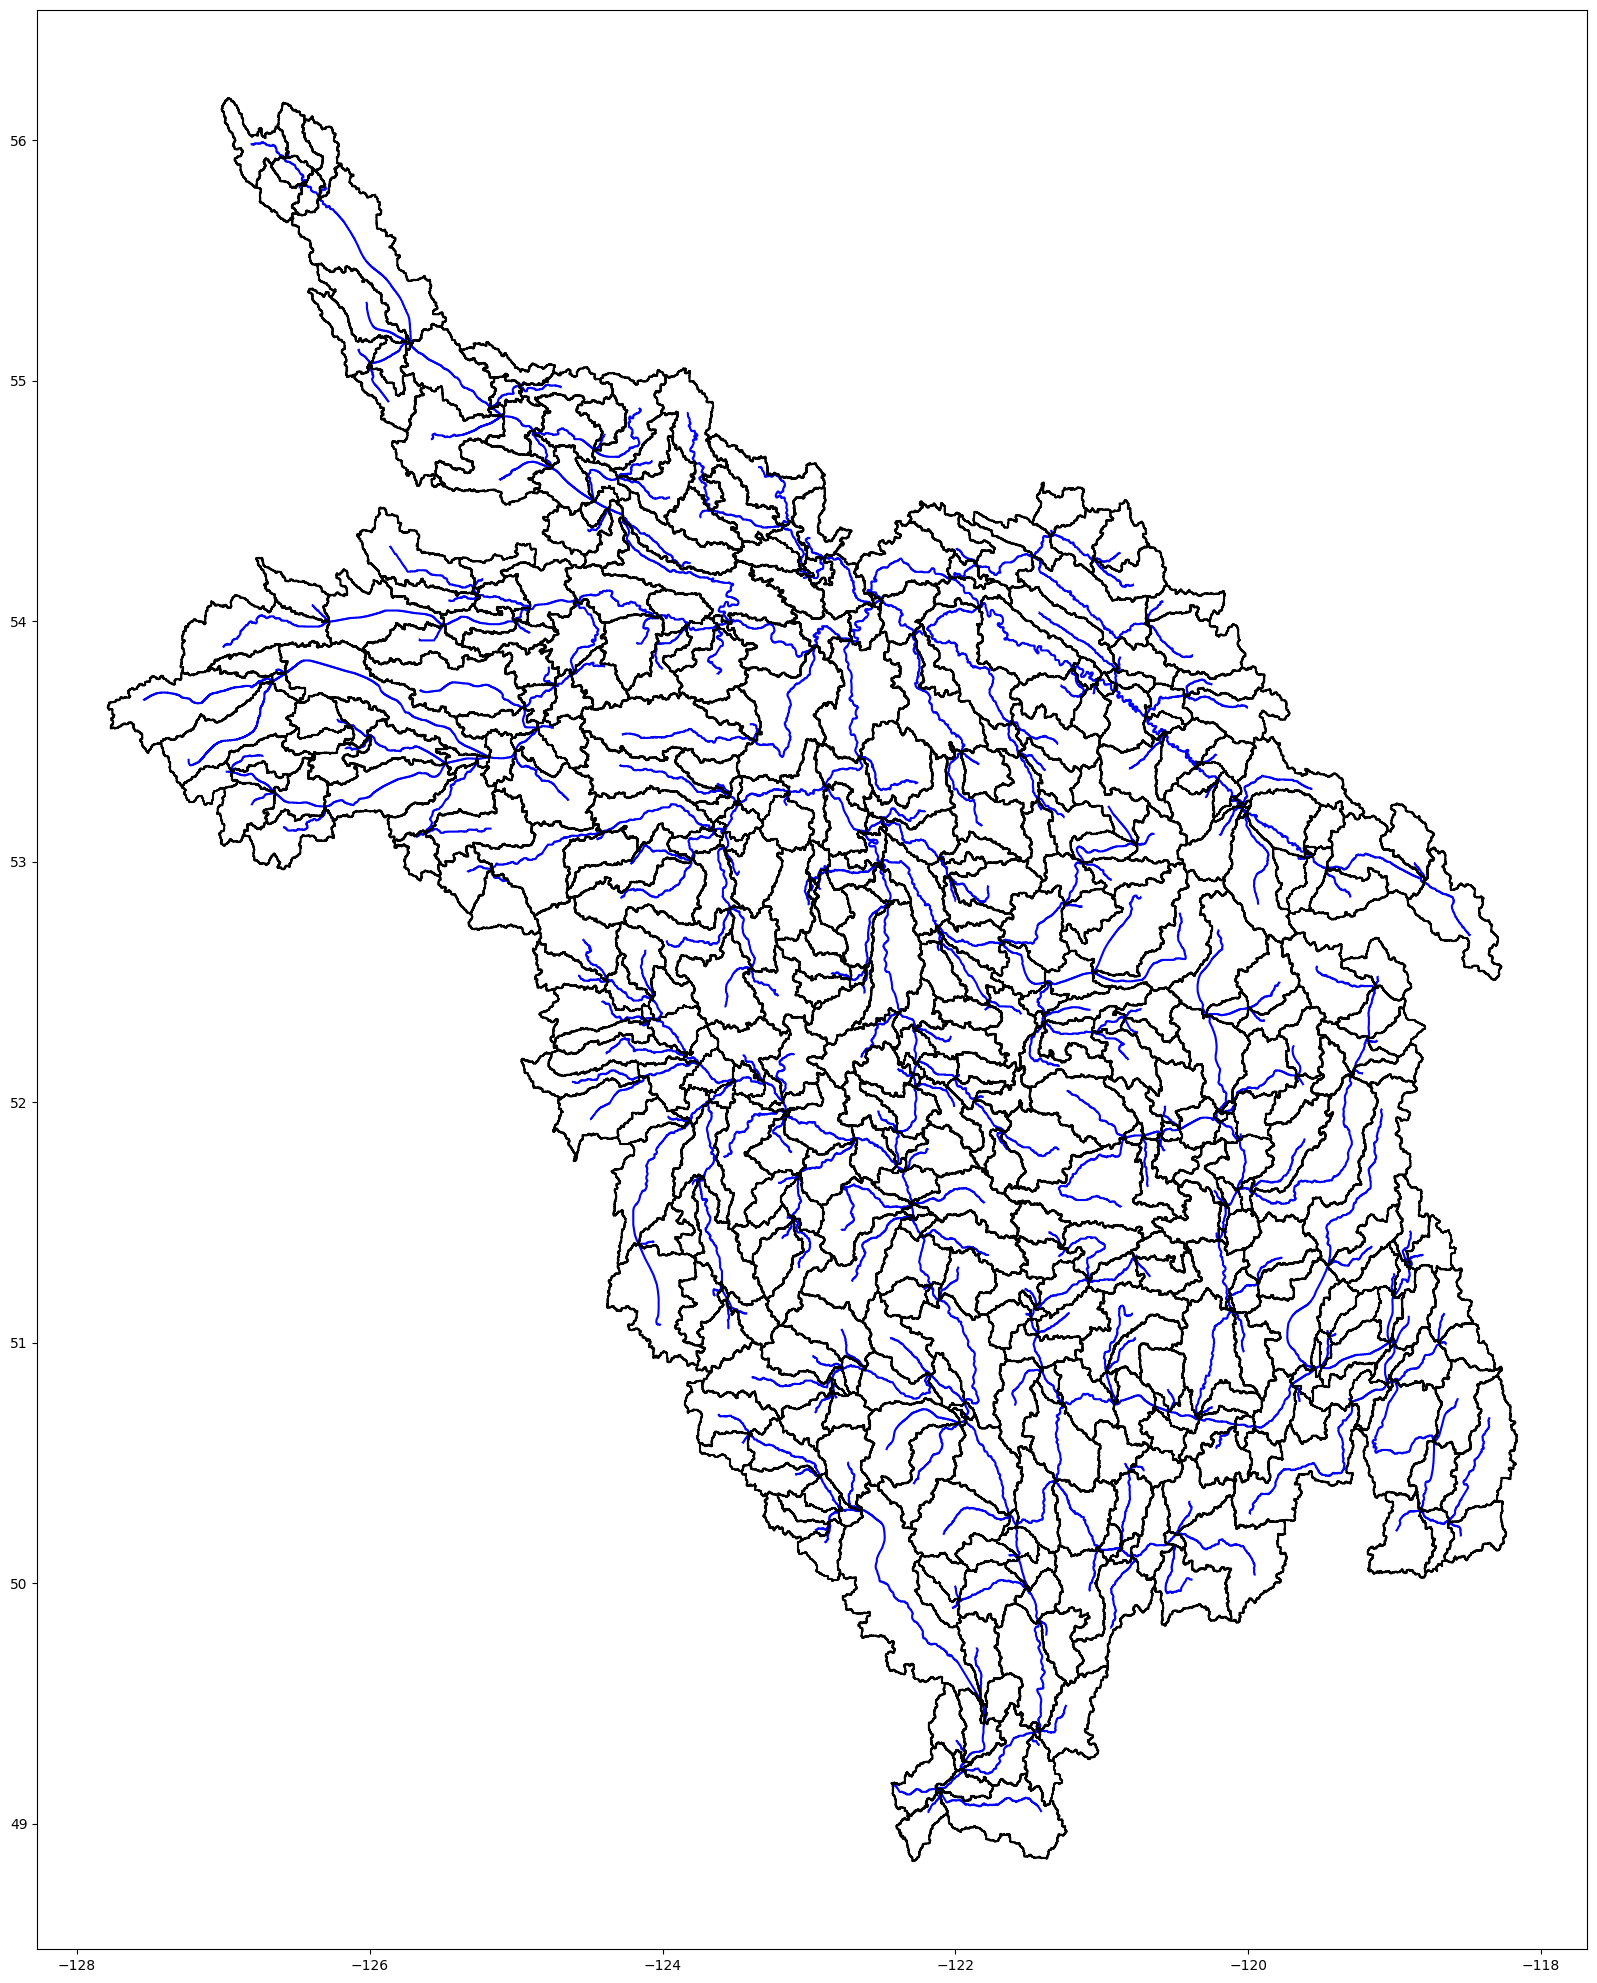

In [8]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

In [9]:
xr_ntopo = gm.create_xr_ntopo(riv_slice,
                              cat_slice,
                              network = 'hdma')
xr_ntopo

<xarray.Dataset>
Dimensions:     (n: 491)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 8 ... 483 484 485 486 487 488 489 490
Data variables: (12/23)
    BotElev     (n) float64 1.035e+03 1.035e+03 733.0 733.0 ... 10.0 6.0 6.0 6.0
    Length      (n) float64 1.786e+04 6.271e+04 ... 1.817e+04 3.967e+04
    OBJECTID    (n) int64 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999 -9999
    PFAF        (n) int64 3146998 3146999 3146996 ... 314141 31415 314133
    PFAF_CODE   (n) int64 314699800000 314699900000 ... 314133000000
    PF_TYPE     (n) int64 6 3 6 3 5 2 6 3 5 4 5 2 6 ... 2 5 4 5 2 5 4 4 2 4 2 2
    ...          ...
    area_org    (n) float64 4.58e+08 1.047e+09 5.411e+08 ... 2.243e+08 5.092e+08
    latitude    (n) float64 53.09 52.78 52.87 53.02 ... 49.29 49.14 49.15 49.18
    longitude   (n) float64 -118.9 -118.6 -119.3 -119.2 ... -122.1 -121.9 -122.2
    width       (n) float64 22.45 33.64 24.49 49.98 ... 470.0 41.44 479.2 481.4
    Rank        (n) int64 1 2 3 4 5 6 7 8 9 ... 484 485 486 487 488 489 490 491
    Rank_Next   (n) int64 4 4 8 8 12 12 14 14 ... 488 489 489 490 490 491 491 0

## save

In [10]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
xr_ntopo.to_netcdf(path_out+prefix+'ntopo.nc')


# Example-2 From basins of identified pfafs that intersect with Alberta and Saskatchewan

In [11]:
# set the case name
prefix = 'ALSASK_hdma_'

In [12]:
# load the info and the provience
trg_shp = gpd.read_file('./data/province/provinces.shp')
sel_pr = ['Alberta','Saskatchewan']
# subsetting `provinces` variable
trg_provinces = trg_shp.loc[trg_shp.PRENAME.isin(sel_pr)].copy().to_crs(epsg=4326)

In [13]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'hruid'},\
                                       riv=riv,\
                                       riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                                       shapefile=trg_provinces)

<AxesSubplot:>

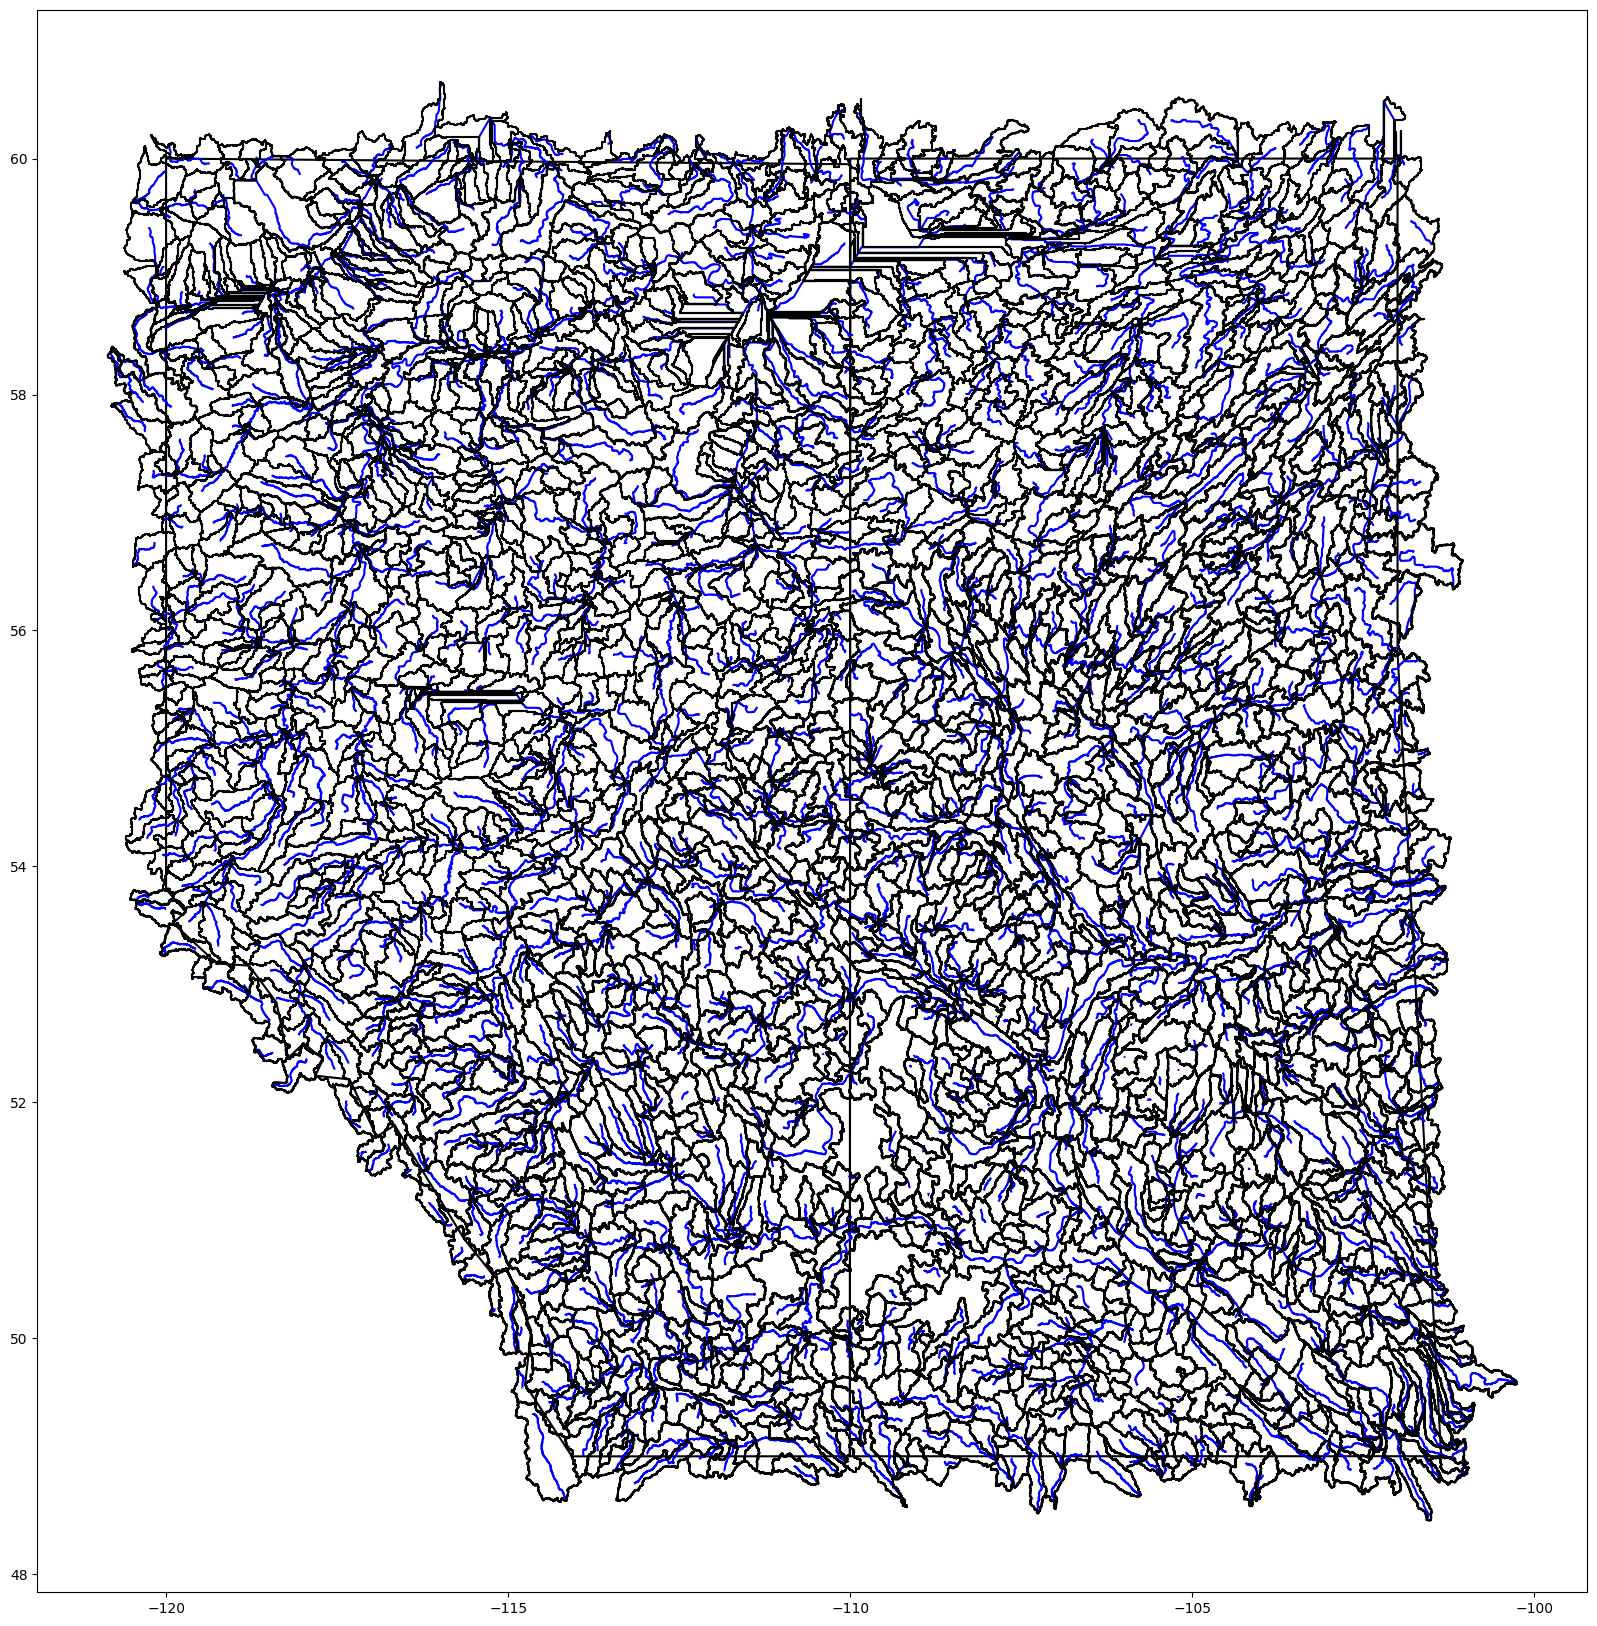

In [14]:
fig, ax = plt.subplots(figsize=(20,30))
trg_provinces.boundary.plot(ax=ax, color='k')
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

In [15]:
xr_ntopo = gm.create_xr_ntopo(riv_slice,
                              cat_slice,
                              network = 'hdma')
xr_ntopo

<xarray.Dataset>
Dimensions:     (n: 3136)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 ... 3129 3130 3131 3132 3133 3134 3135
Data variables: (12/23)
    BotElev     (n) float64 1.035e+03 1.035e+03 360.0 ... -9.999e+03 168.0
    Length      (n) float64 1.786e+04 6.271e+04 3.211e+04 ... 1.0 1.0 3.093e+04
    OBJECTID    (n) int64 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999 -9999
    PFAF        (n) int64 3146998 3146999 336296 3362922 ... -9999 -9999 327931
    PFAF_CODE   (n) int64 314699800000 314699900000 ... -9999 327931000000
    PF_TYPE     (n) int64 6 3 5 6 5 6 5 ... -9999 -9999 -9999 -9999 -9999 1
    ...          ...
    area_org    (n) float64 4.58e+08 1.047e+09 5.67e+08 ... 1.31e+08 1.68e+08
    latitude    (n) float64 53.09 52.78 60.1 59.81 ... 49.26 49.16 49.13 60.06
    longitude   (n) float64 -118.9 -118.6 -103.4 -102.9 ... -104.2 -107.8 -112.2
    width       (n) float64 22.45 33.64 24.91 19.66 ... 5.97 23.4 12.45 784.5
    Rank        (n) int64 1 2 3 4 5 6 7 8 ... 3130 3131 3132 3133 3134 3135 3136
    Rank_Next   (n) int64 2863 2863 2869 2873 2873 2875 2875 ... 0 0 0 0 0 0 0

In [16]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
xr_ntopo.to_netcdf(path_out+prefix+'ntopo.nc')

# Example-3 From basins of identified pfafs that intersect with target stations in Alberta

In [17]:
# set the case name
prefix = 'stations_hdma_'

In [18]:
data = {
    'Station ID': ['05BE004', '05BH004', '05BL004', '05CC002'],
    'seg ID': [3035173, 3037796, 3030143, 3039206],
    'Station name': [
        'BOW RIVER NEAR SEEBE',
        'BOW RIVER AT CALGARY',
        'HIGHWOOD RIVER BELOW LITTLE BOW CANAL',
        'RED DEER RIVER AT RED DEER'
    ],
    'up': [0, 0, 0, 0],
    'X': [-115.03,-114.05,-113.86,-113.82],
    'Y': [  51.11,  51.05,  50.58,  52.27]
}

# Create a DataFrame from the dictionary
stations_seg_id = pd.DataFrame(data)

# Create a points from the dictionary
geometry = [Point(xy) for xy in zip(data['X'], data['Y'])]
stations_points = gpd.GeoDataFrame(data, geometry=geometry, crs='EPSG:4326')

In [19]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'hruid'},\
                                       riv=riv,\
                                       riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                                       outlet_id=list(stations_seg_id['seg ID']))



<AxesSubplot:>

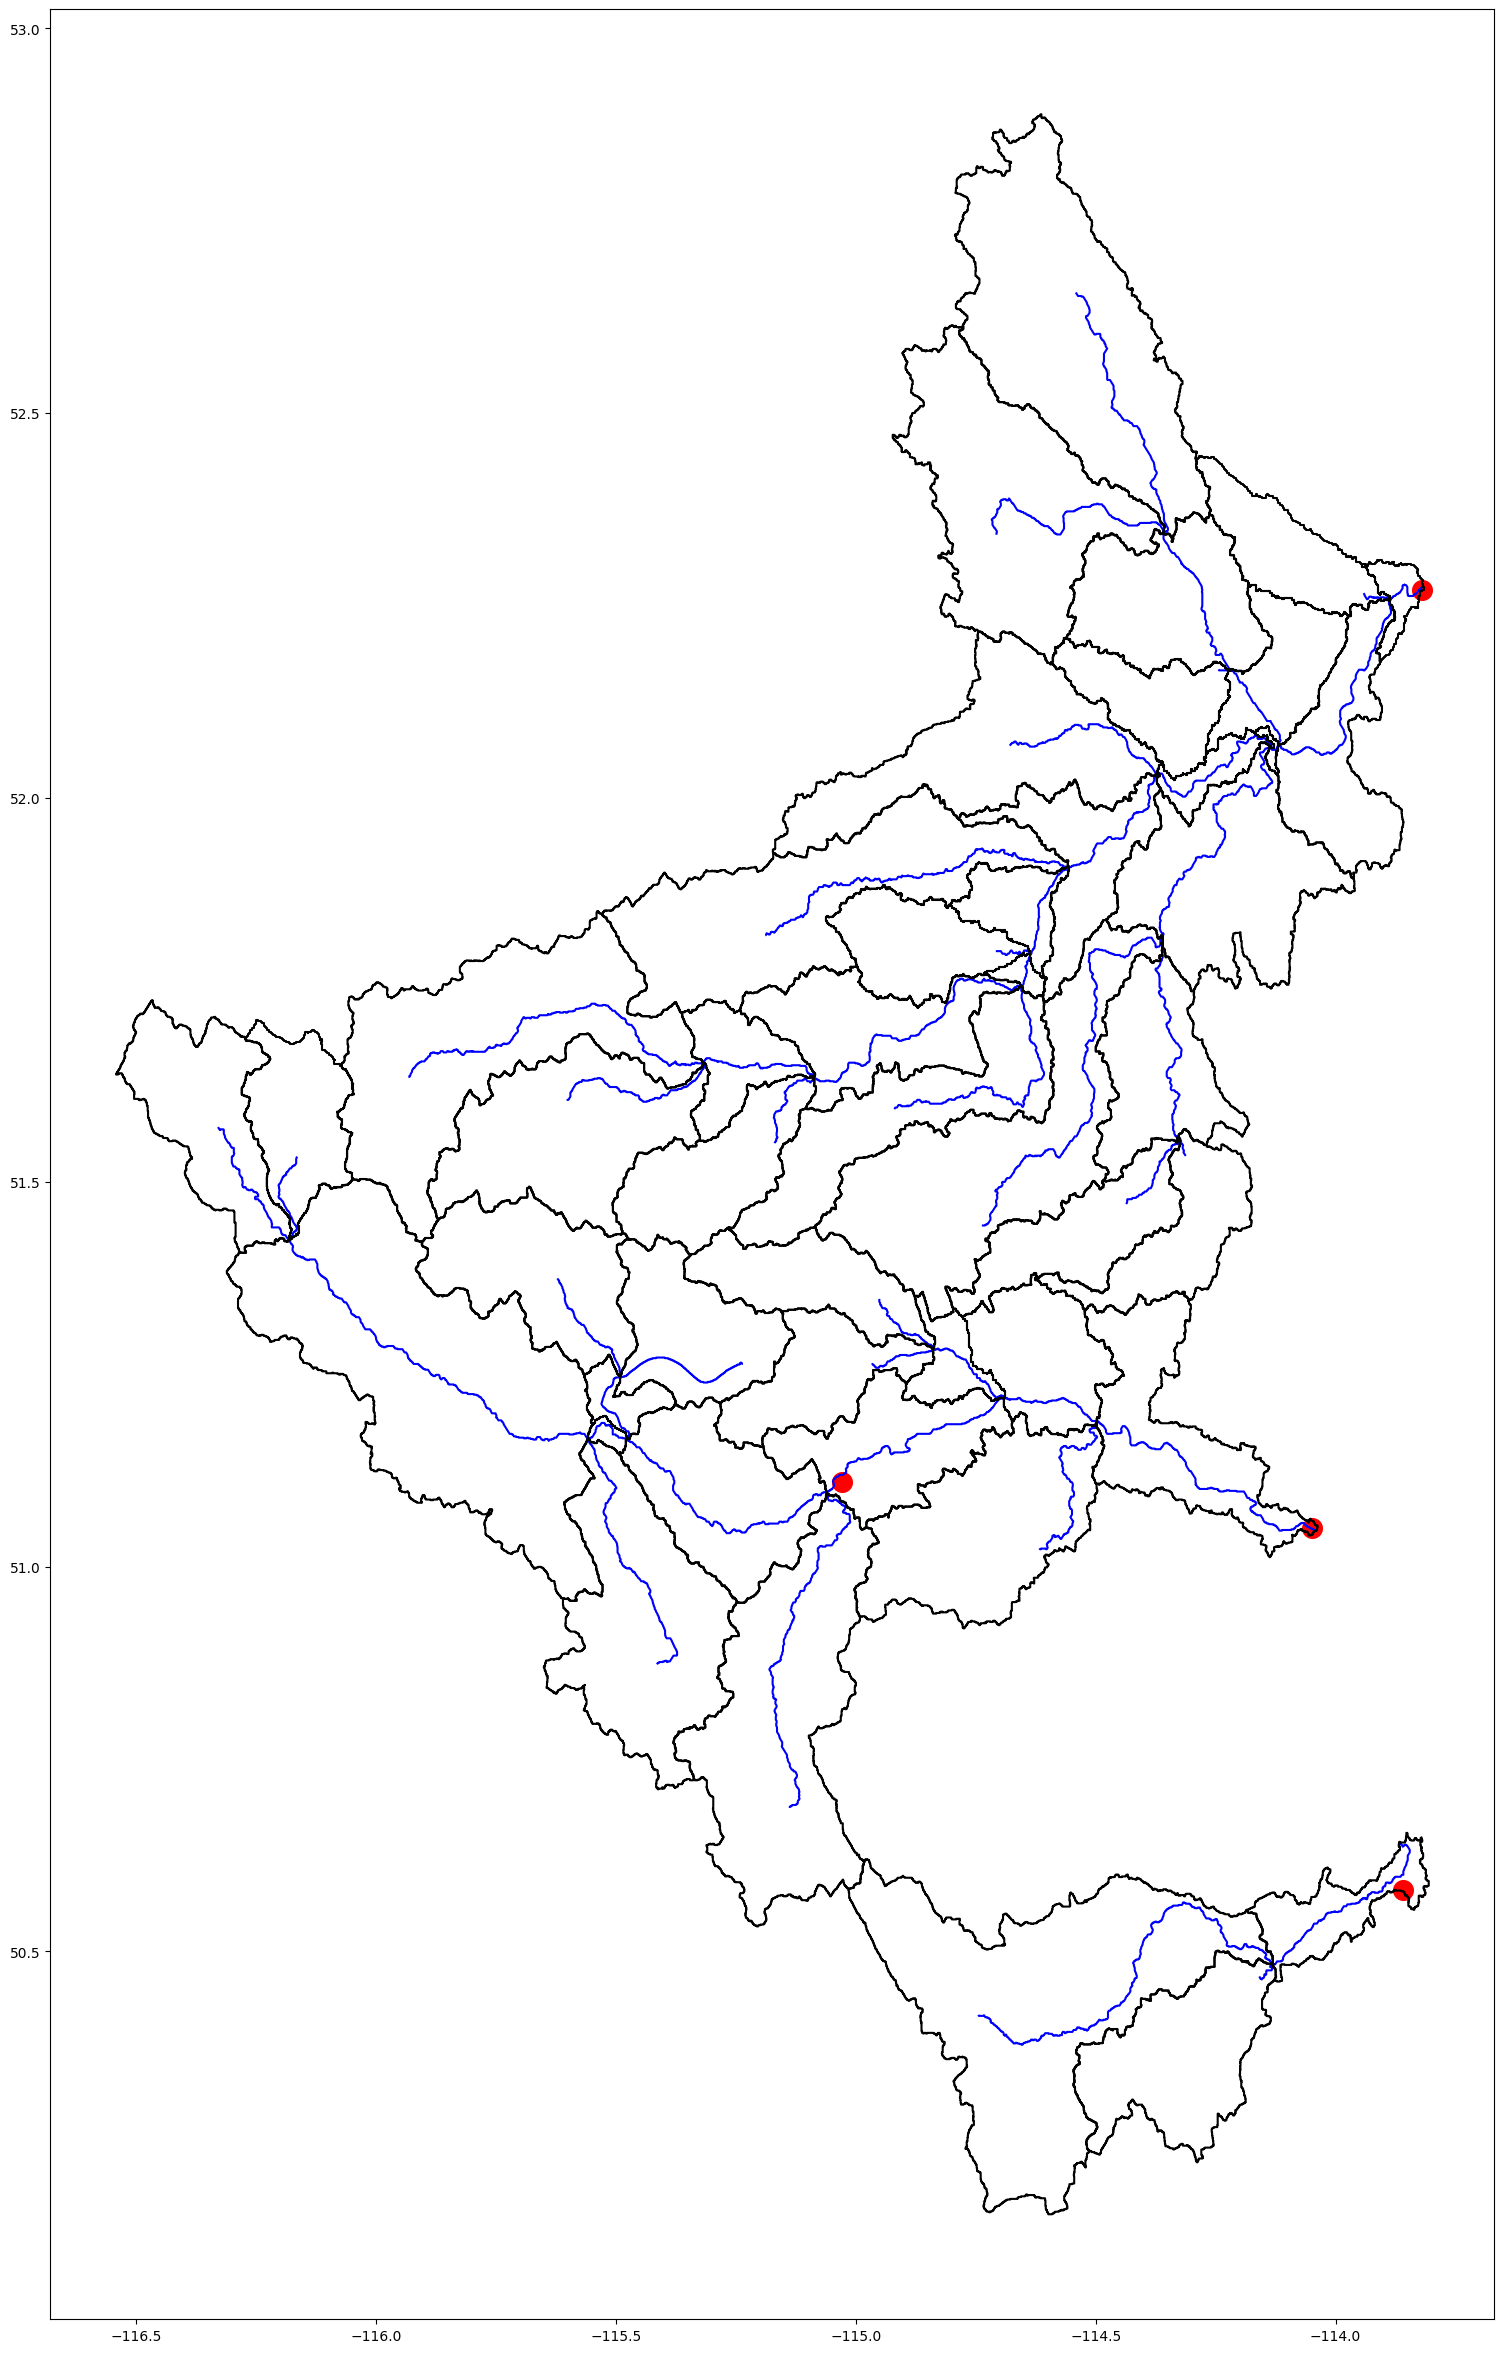

In [20]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')
stations_points.plot(ax=ax, color='r', markersize=200)


In [21]:
xr_ntopo = gm.create_xr_ntopo(riv_slice,
                              cat_slice,
                              network = 'hdma')
xr_ntopo

<xarray.Dataset>
Dimensions:     (n: 47)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45 46
Data variables: (12/23)
    BotElev     (n) float64 1.536e+03 1.536e+03 1.469e+03 ... 1.028e+03 849.0
    Length      (n) float64 1.95e+04 3.688e+04 2.799e+04 ... 3.71e+04 9.113e+03
    OBJECTID    (n) int64 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999 -9999
    PFAF        (n) int64 3428992 3428993 3428962 ... 3428911 342865 3426593
    PFAF_CODE   (n) int64 342899200000 342899300000 ... 342659300000
    PF_TYPE     (n) int64 6 3 6 5 5 3 5 3 6 5 5 3 5 ... 3 5 4 4 3 4 3 6 3 3 4 3
    ...          ...
    area_org    (n) float64 3.036e+08 4.297e+08 ... 1.912e+08 5.211e+07
    latitude    (n) float64 51.58 51.59 51.31 51.38 ... 52.05 51.18 50.55 52.26
    longitude   (n) float64 -116.2 -116.4 -115.3 -115.7 ... -114.3 -114.0 -113.9
    width       (n) float64 18.54 21.86 20.67 23.17 ... 108.1 90.36 45.98 109.6
    Rank        (n) int64 1 2 3 4 5 6 7 8 9 10 ... 38 39 40 41 42 43 44 45 46 47
    Rank_Next   (n) int64 6 6 7 7 8 8 12 12 13 13 ... 41 42 42 44 44 47 47 0 0 0

In [22]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
xr_ntopo.to_netcdf(path_out+prefix+'ntopo.nc')